# Quantitative Analysis

 In this tutorial, we'll make use of a ground truth phantom and corresponding projection data obtained using SIMIND. We'll use attenuation correction, PSF correction, scatter correction, and priors to compare the reconstruction of SIMIND SPECT simulation data to the corresponding ground truth phantom.

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pytomography
from pytomography.algorithms import OSEMBSR
from pytomography.priors import RelativeDifferencePrior
from pytomography.metadata import PSFMeta
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projections import SystemMatrix
from pytomography.callbacks import CallBack
from pytomography.io import simind_CT_to_data, simind_projections_to_data, simind_MEW_to_data
from scipy.ndimage import zoom
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Set the device used in pytomography, and the path where you saved the files (you will need to modify path)

In [2]:
pytomography.device = device
path = '/home/gpuvmadm/PyTomography/test_files/quantitative' 

## Part 1: Setting Up The Phantom

Firstly, we'll open the ground truth phantom

In [3]:
GT = np.fromfile(os.path.join(path,'body1_Lu177_T2.bin'), dtype=np.float32)
GT.shape

(196870144,)

We'll need to reshape it into a 3D array. In this case, I know that the shape of the phantom is (751x512x512) because I created it as such.

In [4]:
GT = GT.reshape((751,512,512))

Now we should make sure the axes align with pytomography standards (`axis=0` is x, `axis=1` is y, and `axis=2` is z). The data was saved in the opposite order, so I need to transpose it.

In [5]:
GT = np.transpose(GT, (2,1,0))
GT = np.pad(GT, ((0,0),(0,0),(8,8)))

Now we can plot it. Let's look at a $x-z$ maximum intensity projection of the phantom.

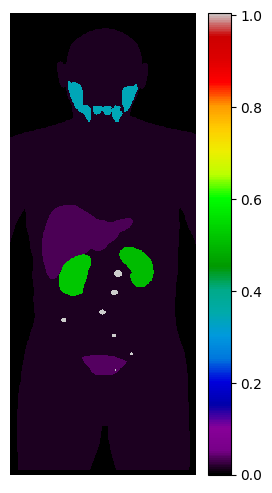

In [6]:
plt.figure(figsize=(3,6))
plt.pcolormesh(GT.max(axis=1).T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.show()

This constitutes our ground truth; the units are MBq/mL. In a short moment, we'll open our SPECT projection data, and run our iterative reconstruction algorithm to compare the true activity in each organ to the reconstructed object's activity as a function of iteration number. To do this, we'll need masks for each organ.

* It very well may be the case that the ground truth object is of different dimensions than the reconstructed object. In our case, the ground truth is of shape 512x512x751 and the reconstructed object (as we will see shortly) will be of shape 128x128x384. So long as the two objects are algined, we can simply resize the ground truth phantom so the arrays have the same dimensions.

* In this case, I know the precise activity values in each organ/lesion, so it's easy to make masks.

In [7]:
activities = {'bkg':0.0146, 'liver':0.0333, 'lungs':0.0146, #body1
         'rkidcor':0.521, 'lkidcor':0.504, 'rkidmel':0.287,
         'lkidmel':0.21, 'sal':0.338, 'bla':0.0371, 'les':1.01}
def get_mask(arr, val, pct=1):
    arr = (arr<val+(pct/100)*val)*(arr>val-(pct/100)*val)
    arr = zoom(arr, (128/512, 128/512, 3*128/767), order=0, mode='nearest')
    return torch.tensor(arr.copy()).to(device)

This function allows me to create a mask in a region with value `val`$\pm$`pct`. For example, if I wanted a mask of the liver:

In [8]:
liver_mask = get_mask(GT, activities['liver'])
liver_mask.shape

torch.Size([128, 128, 384])

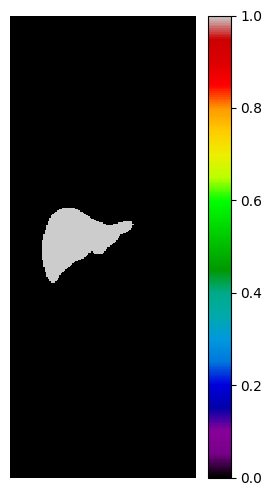

In [9]:
plt.figure(figsize=(3,6))
plt.pcolormesh(liver_mask.cpu().numpy().max(axis=1).T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.show()

This mask will allow me to compare the true activity of the liver (0.0735MBq/mL) to the value obtained from the reconstruction in that region.

## Part 2: Getting The Calibration Factor

Since our SPECT data is measured in MBq/mL and the SPECT reconstruction will be in units of counts, we need a way to convert between units. You may be tempted to think that 1Bq = 1 count per second, but this is not true for a scan where "counts" actually means "detected counts". In general, a detector is not 100% efficient (far from it) so most radioactive counts go undetected (in SPECT, they may not be parallel with the collimators).

 Regardless, we can still get an empirical conversion factor by scanning a point source of known activity inside the scanner. Let's open some projection data corresponding to a point calibtation scan:

In [10]:
object_meta, image_meta, projections = simind_projections_to_data(os.path.join(path, 'pointcalib1.h'))

Let's look at the first projection:

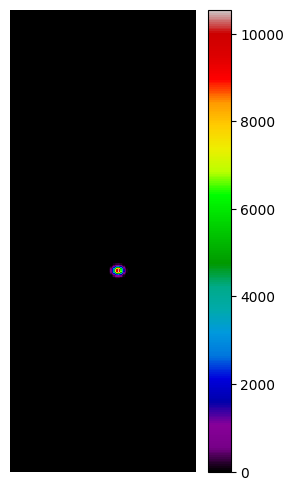

In [11]:
plt.figure(figsize=(3,6))
plt.pcolormesh(projections[0][0].T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.show()

In [12]:
total_counts = projections[0][0].sum().item()
dV = object_meta.dr[0] * object_meta.dr[1] * object_meta.dr[2] # units: cm^3 = mL

In this case, the activity of the point source was 1700MBq, and the scan was taken for 15s. The colorbar shows the total number of detected counts. The number of MBq/mL per CPS is thus

In [13]:
CPS_to_MBQpermL = (1700/dV)/(total_counts)
CPS_to_MBQpermL

0.21089022221130554

So after reconstructing our object (which gives units of detected counts), we need to multiply by that factor to get units of MBq/mL, which we can use to compare to our phantom.

## Part 3: Reconstructing SPECT Data

Now we will reconstruct our SPECT data, and compare it to the original phantom. In particular, since we're using an iterative algorithm, we'll want to see how the improvements as a function of iterations. We'll get to that later.

First we'll open the SPECT scan. Since we have multiple energy windows (we'll be using the triple energy window scatter correction method), we'll use the `simind_MEW_to_data` function. First, we can opt to have `return_seperate=True` so that we can look at each energy window. In the case, the batch dimension of `projections` contains a seperate image at each energy window.

In [14]:
header_files = [os.path.join(path, f'body1t2ew6_tot_w{i}.hdr') for i in [2,1,3]]
object_meta, image_meta, projections, projections_scatter = simind_MEW_to_data(header_files, distance='cm')

/tmp/ipykernel_30238/2933345111.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


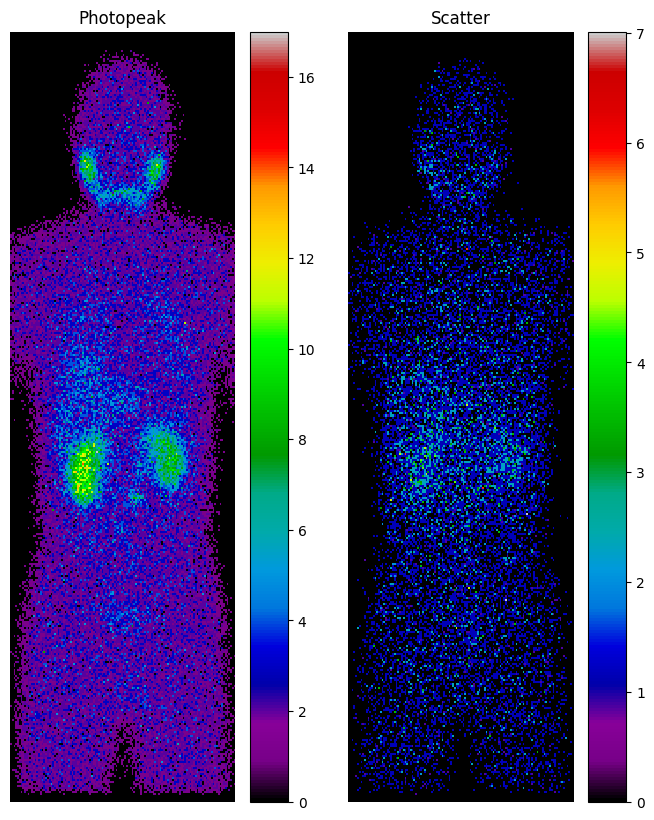

In [15]:
plt.subplots(figsize=(8,10))
plt.subplot(121)
plt.pcolormesh(projections[0,0].cpu().numpy().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.title('Photopeak')
plt.subplot(122)
plt.pcolormesh(projections_scatter[0,0].cpu().numpy().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar()
plt.title('Scatter')
plt.show()

Now we can load the corresponding CT image from SIMIND using the `simind_CT_to_data` function.

In [16]:
CT = simind_CT_to_data(os.path.join(path, f'body1.hct')).unsqueeze(dim=0)

Now we need to set up all our CorrectionNets during reconstruction. This includes PSF correction, attenuation correction, and corresponding priors we want to use.

* PSF modeling. This requires knowing the `collimator_slope` and `collimator_intercept` parameters of the scanner. The assumption is that the PSF function is Gaussian with width $\sigma$ dependent on the distance from the detector: 
$\sigma =$ `collimator_slope` $\cdot d + $ `collimator_intercept`. This information depends on the detector used: in particular, the collimator dimensions. These may be found in a data sheet for your particular scanner. It can also be determined by scanning a point source at various detector distances $d$, fitting each projection to a Gaussian profile and determining the width $\sigma$, and then fitting $d$ vs. $\sigma$ to a linear curve: 

In [18]:
collimator_slope = 0.03013
collimator_intercept = 0.1967
psf_meta = PSFMeta(collimator_slope, collimator_intercept, '2D')
psf_net = SPECTPSFTransform(psf_meta)

* Attenuation correction modeling

In [19]:
ct_net = SPECTAttenuationTransform(CT)

* Priors. We'll compare no prior to the QClear prior.

In [20]:
rdp = RelativeDifferencePrior(beta=2, gamma=10)

Next we'll create a subclass of the `CallBack` class. "What's the purpose of this?", you may be wondering.

 An instance of a callback class can be passed to an iterative reconstruction algorithm, and the user-defined `run` method is called after each subiteration (it's passed the reconstructed object `obj` corresponding to that iteration). In this case, we define the `CompareToGroundTruth` class, and initialize it with the ground truth phantom. After each iteration, when `run` is called, it compares the reconstructed object to the ground truth phantom, and stores corresponding biases and variances in the `self.biass` and `self.vars` dictionaries for each organ. Depending on your task, you can define a callback function to compute whatever you need after each iteration.
* For example, as an exercise, you could modify this class to store the reconstructed image with the lowest mean squared error relative to the ground truth phantom.

In [21]:
class CompareToGroundTruth(CallBack):
    def __init__(self, GT, activity_dict, calibration_factor, device = None):
        self.device = pytomography.device if device is None else device
        self.GT = GT
        self.calibration_factor = calibration_factor
        self.activity_dict = activity_dict
        self.organ_keys = activity_dict.keys()
        self.mask_dict = {key: self.get_mask(activity_dict[key]) for key in self.organ_keys}
        self.biass = {key: [] for key in self.organ_keys}
        self.vars = {key: [] for key in self.organ_keys}
        self.vals = {key: [] for key in self.organ_keys}
    def get_mask(self, val, pct=1):
        arr = (self.GT<val+(pct/100)*val)*(self.GT>val-(pct/100)*val)
        arr = zoom(arr, (128/512, 128/512, 384/767), order=0, mode='nearest')
        return torch.tensor(arr.copy()).unsqueeze(dim=0).to(self.device)
    def run(self, obj):
        obj_cal = obj *self.calibration_factor
        for key in self.organ_keys:
            self.biass[key].append(torch.mean(obj_cal[self.mask_dict[key]] - self.activity_dict[key]).item())
            self.vars[key].append(torch.var(obj_cal[self.mask_dict[key]] - self.activity_dict[key]).item())
            self.vals[key].append(torch.mean(obj_cal[self.mask_dict[key]]).item())

Now we'll define  a function which automates the reconstruction process. In particular, it takes in a `callback`, the number of iterations/subsets, a prior function to use, and the corresponding correction nets used during reconstruction. It then runs the `OSEMBSR` algorithm and returns the final image as output.

In [22]:
def reconstruct_object(callback, n_iters, n_subsets, projections, prior, scatter, object_correction_nets, image_correction_nets):
    system_matrix = SystemMatrix(object_correction_nets, image_correction_nets,
                                object_meta, image_meta)
    reconstruction_algorithm = OSEMBSR(projections, system_matrix, scatter=scatter, prior=prior)
    return reconstruction_algorithm(n_iters, n_subsets, callback=callback)

Now we define instances of the `CompareToGroundTruth` which we use as a callback function during reconstruction. We'll be comparing standard reconstruction to reconstruction using the relative difference prior: hence the naming convention.

In [23]:
stats_generic = CompareToGroundTruth(GT, activities, calibration_factor=CPS_to_MBQpermL)
stats_qclear = CompareToGroundTruth(GT, activities, calibration_factor=CPS_to_MBQpermL)

Now we reconstruct the objects: one time using no prior, and one time using the relative difference prior.

In [24]:
reconstructed_object = reconstruct_object(stats_generic, 2, 8, projections, None, projections_scatter, [ct_net, psf_net], [])
reconstructed_object_qclear = reconstruct_object(stats_qclear, 10, 8, projections, rdp, projections_scatter, [ct_net, psf_net], [])

Let's visualize MIP of the reconstructed objects.

In [25]:
o1 = reconstructed_object[0][:,64].cpu().numpy().T*CPS_to_MBQpermL
o2 = reconstructed_object_qclear[0][:,64].cpu().numpy().T*CPS_to_MBQpermL
GT_resized = zoom(GT, (128/512, 128/512, 384/767), order=0, mode='nearest')[:,64].T

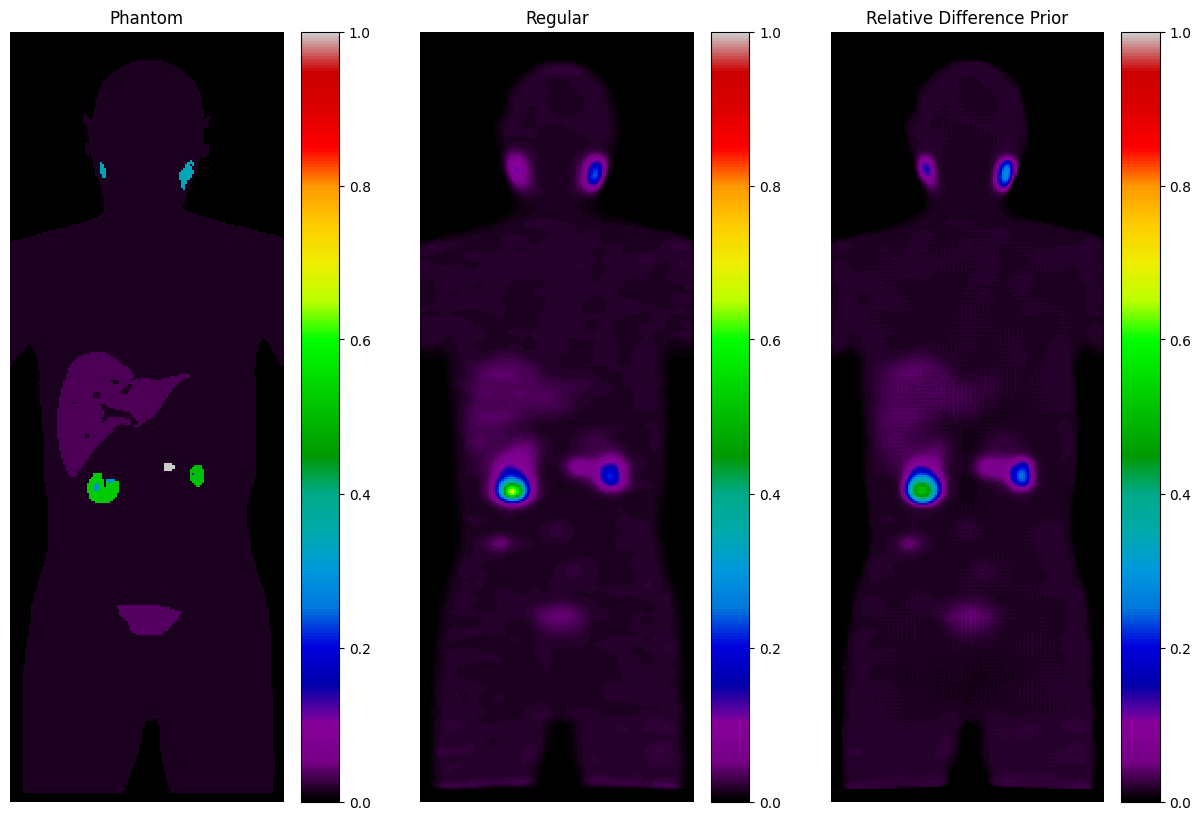

In [26]:
plt.subplots(1,3,figsize=(15,10))
plt.subplot(131)
plt.pcolormesh(GT_resized, cmap='nipy_spectral', vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('Phantom')
plt.subplot(132)
plt.pcolormesh(o1,cmap='nipy_spectral', vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('Regular')
plt.subplot(133)
plt.pcolormesh(o2, cmap='nipy_spectral', vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('Relative Difference Prior')
plt.show()

Finally, here's some code written to plot/compare noise-bias curves for each reconstruction algorithm.

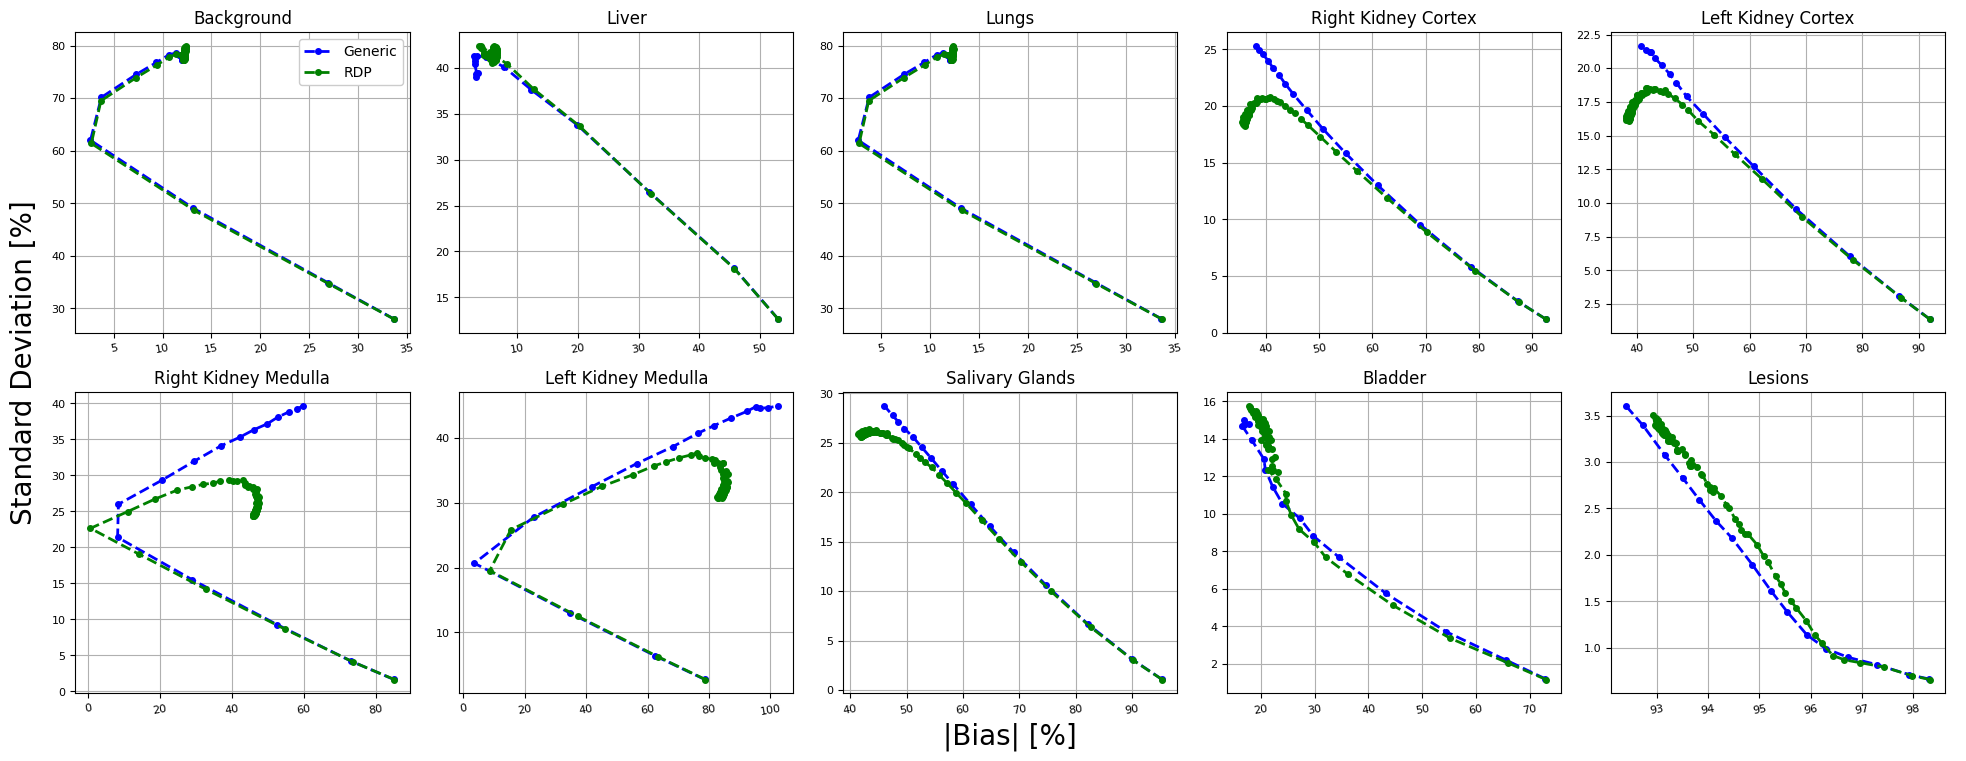

In [27]:
def plot_bvc(statistics, organ, ax, color, label):
    ax.plot(np.abs(statistics.biass[organ])/activities[organ] *100, np.sqrt(statistics.vars[organ])/activities[organ] * 100, ls='--', marker='o', markersize=4, lw=2, color=color, label=label)
    
title_dict = {'bkg': 'Background', 'liver': 'Liver', 'lungs': 'Lungs', 'rkidcor': 'Right Kidney Cortex',
             'lkidcor': 'Left Kidney Cortex', 'rkidmel': 'Right Kidney Medulla', 'lkidmel': 'Left Kidney Medulla',
             'sal': 'Salivary Glands', 'bla': 'Bladder', 'les':'Lesions'}

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for ax, organ in zip(axes.ravel(), activities.keys()):
    plot_bvc(stats_generic, organ, ax, 'blue', 'Generic')
    plot_bvc(stats_qclear, organ, ax, 'green', 'RDP')
    #plot_bvc(stats_qclear, organ, ax, 'red', 'QClear')
    ax.grid()
    ax.tick_params(axis='y', which='major', labelsize=8)
    ax.tick_params(axis='x', which='major', labelsize=8, rotation=10)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_title(title_dict[organ])
axes[0,0].legend(facecolor='white', framealpha=1, frameon=True, loc='upper right')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("|Bias| [%]", fontsize=20)
plt.ylabel("Standard Deviation [%]", fontsize=20)
fig.tight_layout()

The relative difference prior appears to give significant improvement in the Kidneys and salivary glands: both medium sized organs.